In [21]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [6]:
g0 = 9.80665

In [52]:
import numpy as np


class Rocket:
    def __init__(self, ics):
        self.mass = ics['m0']  # kg
        self.mf = ics['mf'] 
        self.isp = ics['isp']   # s
        self.vex = self.isp * g0
        self.thrust = ics['thr']  # N
        self.mdot = self.thrust / (self.vex)
        self.altitude = ics['h0']   # m
       
        self.vy = ics['hdot0']   # m/s

        vx0 = np.sqrt(ics['v0']**2 -  ics['hdot0'] **2)  # m/s

        self.vx = vx0
        self.time = [0]  # storing time
        self.masses = [ics['m0']]
        self.x_positions = [0]  # storing x positions over time
        self.y_positions = [ics['h0']]  # storing y positions over time
        self.x_velocities = [vx0]  # storing x velocities over time
        self.y_velocities = [ics['hdot0']]  # storing y velocities over time

        self.theta =ics['theta0']
        
        self.pitch_angles_deg = [self.theta]  # storing pitch angles over time

    def grav_acc(self):
        # Calculate distance from the center of the Earth
        r = 6371000 + self.altitude  # Radius of the Earth + altitude

        # Calculate acceleration due to gravity
        mu = 3.986e14  # Gravitational parameter of Earth (m^3/s^2)
        return mu / r**2  # m/s^2

    def theta_guidance_simple(self):

        theta_new = 90 -0.15 * self.vy 

        self.theta = max(min(theta_new, 85), 5)

    def theta_guidance_apo(self):
        

        if (self.vy < 50) :
            return
        
        b = self.grav_acc() / (self.thrust/self.mass)

        x = np.arcsin(1/b)

        theta_new = np.rad2deg(x)

        self.theta = max(min(theta_new, 85), 5)

    def teta_guidance_cont(self):

        debug = False

        href = 80000

        dh = abs(self.altitude - href)

        sinth_ = np.sin(np.deg2rad(self.theta))
        costh_ = np.cos(np.deg2rad(self.theta))

        athr_ = self.thrust/self.mass

        g_ = self.grav_acc()

        a_ = athr_*sinth_ - g_

        if debug:
            print(a_)

        t = (-self.vy - np.sqrt(self.vy**2 - 2*a_*dh))/(a_)

        if debug:
            print(t)

        if (t < 30):
            return

        b_ = (self.vy/t - g_) / athr_

        c_ = (self.vy/t) / athr_

        fpa = (b_ + sinth_) / (c_ + costh_)

        fpadot = (c_*costh_ + c_*sinth_ + 1)/(c_ + costh_)**2

        theta_new = self.theta + fpa / fpadot
        
        self.theta = max(min(theta_new, 85), 5)

        if debug:
            print ('----------------------')

    def theta_simulate(self, time_step, total_time, cut_alt, guid):
        current_time = 0
        sim_end = False
        while (not sim_end):

            # Update time
            current_time += time_step
            self.time.append(current_time)

            m1 = self.mass - self.mdot * time_step

            if (m1 <= self.mf):
                m1 = self.mf
                self.mdot = 0

            self.mass = m1
        
            self.masses.append(self.mass)

            if guid:
                self.theta_guidance_simple() 
            
            # Update pitch angle from degrees to radians
            pitch_angle_rad = np.deg2rad(self.theta)

            gravity = self.grav_acc()

            # Thrust components
            thr = self.thrust

            if (self.mdot == 0):
                thr = 0
            
            thrust_x = thr * np.cos(pitch_angle_rad)
            thrust_y = thr * np.sin(pitch_angle_rad)

            # Acceleration components
            ax = thrust_x / self.mass
            ay = thrust_y / self.mass - gravity  # gravity varies with altitude

            # Update velocities
            self.vx += ax * time_step
            self.vy += ay * time_step

            # Update positions
            self.x_positions.append(self.x_positions[-1] + self.vx * time_step)
            self.y_positions.append(self.y_positions[-1] + self.vy * time_step)

            # Update velocities
            self.x_velocities.append(self.vx)
            self.y_velocities.append(self.vy)


            # Update pitch angle (not implemented in this example)

            # Append pitch angle in degrees
            self.pitch_angles_deg.append(self.theta)

            #end conditions
            sim_end = (current_time >= total_time) or (self.y_positions[-1] <= cut_alt and self.vy < 0)

    def plot_results(self):
        fig, axs = plt.subplots(4, figsize=(10, 16))

        # Plot trajectory
        axs[0].plot(self.x_positions, self.y_positions)
        axs[0].set_xlabel('X Position (m)')
        axs[0].set_ylabel('Y Position (m)')
        axs[0].set_title('Rocket Trajectory')

        # Plot pitch angle
        axs[1].plot(self.time, self.masses)
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel('mass')

        # Plot velocities
        axs[2].plot(self.time, self.x_velocities, label='X Velocity')
        axs[2].plot(self.time, self.y_velocities, label='Y Velocity')
        axs[2].set_xlabel('Time')
        axs[2].set_ylabel('Velocity (m/s)')
        axs[2].set_title('Rocket Velocities')
        axs[2].legend()

        # Plot pitch angle
        axs[3].plot(self.time, self.pitch_angles_deg)
        axs[3].set_xlabel('Time')
        axs[3].set_ylabel('Pitch Angle (degrees)')
        axs[3].set_title('Pitch Angle over Time')

        plt.tight_layout()
        plt.show()


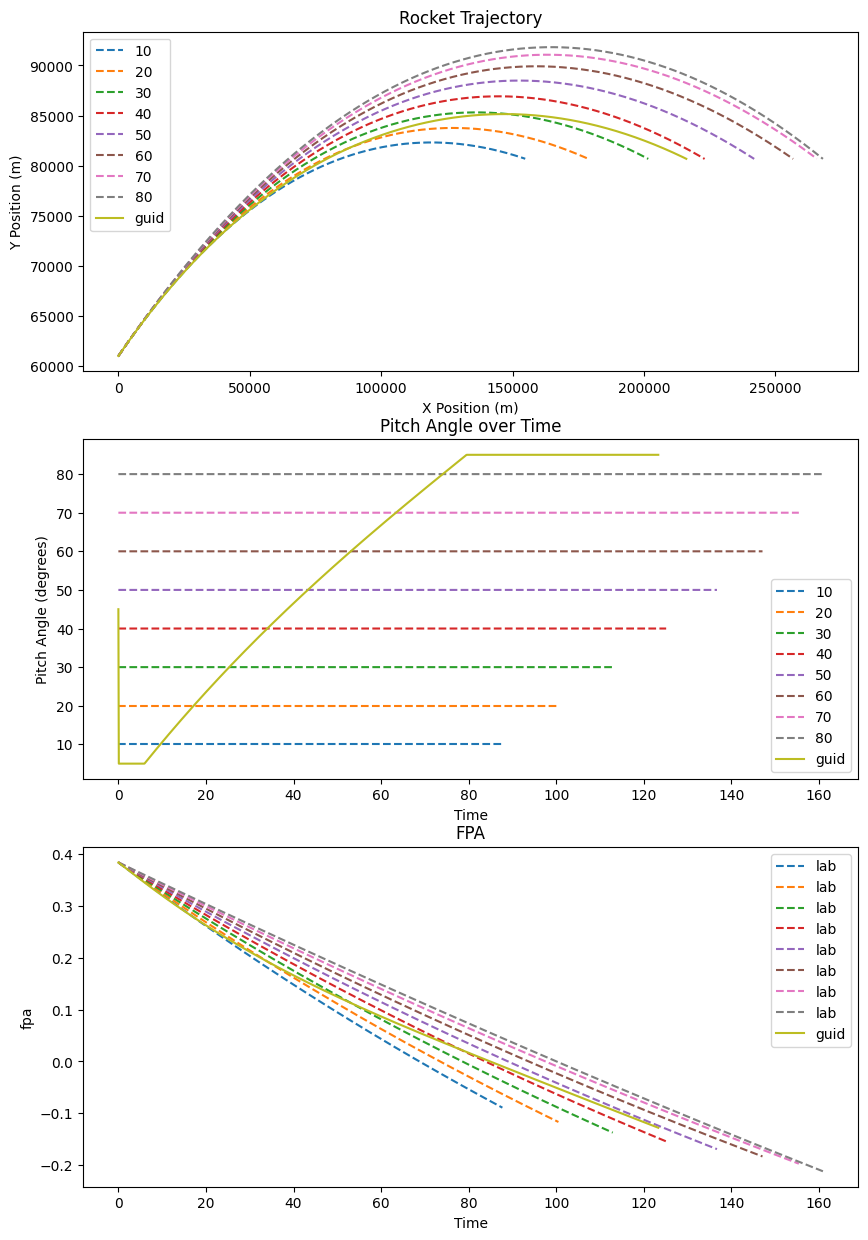

In [58]:
#2eo at t+148
ic1 = {
    'm0' : 649993,
    'mf' : 121857.8,
    'isp' : 453.5,
    'thr' : 2173600,
    'h0' : 61000,
    'v0' : 1732.6,
    'hdot0' : 621.4,
    'theta0' : 45
}

#2eo at t+200
ic2 = {
    'm0' : 573558,
    'mf' : 121857.8,
    'isp' : 453.5,
    'thr' : 2173600,
    'h0' : 92830,
    'v0' : 2131.7,
    'hdot0' : 435.4,
    'theta0' : 45
}

#2eo at t+243
ic3 = {
    'm0' : 509941,
    'mf' : 121857.8,
    'isp' : 453.5,
    'thr' : 2173600,
    'h0' : 108430,
    'v0' : 2564.5,
    'hdot0' : 289.5,
    'theta0' : 45
}


#2eo at t+340
ic4 = {
    'm0' : 367836,
    'mf' : 121857.8,
    'isp' : 453.5,
    'thr' : 2173600,
    'h0' : 122380,
    'v0' : 3908.4,
    'hdot0' : 15.6,
    'theta0' : 45
}


ics = ic1

# Create rocket object


# Simulation parameters
time_step = 0.1  # s
total_time = 1000  # s
cut_alt = 80700

fig, axs = plt.subplots(3, figsize=(10, 15))

for theta_ in np.arange(10, 90, 10):

    ics_theta = copy.deepcopy(ics)

    ics_theta['theta0'] = theta_

    rocket = Rocket(ics_theta)

    rocket.theta_simulate(time_step, total_time, cut_alt, False)

    lab = str(theta_)

    axs[0].plot(rocket.x_positions, rocket.y_positions, '--', label = lab)
    axs[0].set_xlabel('X Position (m)')
    axs[0].set_ylabel('Y Position (m)')
    axs[0].set_title('Rocket Trajectory')
    axs[0].legend()

    # Plot pitch angle
    axs[1].plot(rocket.time, rocket.pitch_angles_deg, '--', label = lab)
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Pitch Angle (degrees)')
    axs[1].set_title('Pitch Angle over Time')
    axs[1].legend()

    # Plot fpa
    axs[2].plot(rocket.time,  np.divide(rocket.y_velocities , rocket.x_velocities),'--',  label='lab')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('fpa')
    axs[2].set_title('FPA')
    axs[2].legend()



rocket = Rocket(ics)

rocket.theta_simulate(time_step, total_time, cut_alt, True)

axs[0].plot(rocket.x_positions, rocket.y_positions, label = 'guid')
axs[0].set_xlabel('X Position (m)')
axs[0].set_ylabel('Y Position (m)')
axs[0].set_title('Rocket Trajectory')
axs[0].legend()

# Plot pitch angle
axs[1].plot(rocket.time, rocket.pitch_angles_deg, label = 'guid')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Pitch Angle (degrees)')
axs[1].set_title('Pitch Angle over Time')
axs[1].legend()

# Plot fpa
axs[2].plot(rocket.time,  np.divide(rocket.y_velocities , rocket.x_velocities), label='guid')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('fpa')
axs[2].set_title('FPA')
axs[2].legend()


